In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 14, "axes.titlesize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("colorblind"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = 'open_lth_data'

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
def get_accuracy_val_from_hash(exp_hash, num_reps, object_store, num_levels):
    #exp_hash = utils.get_hash(exp.name)
    accs = np.zeros((num_reps, num_levels+1))
    for rep in range(num_reps):
        acc_level = []
        for level in range(num_levels+1):       
            object_store.download_object(
                f"{bucket_dir}/{exp_hash}/replicate_{rep+1}/level_{level}/main/logger", "temp"
            )
            df = pd.read_csv("temp", header=None)
            acc_level.append(df[2].iloc[-2])
            os.remove("temp")
        accs[rep, :] = acc_level
    return accs

In [18]:
accs_rt = get_accuracy_val_from_hash('lottery_93bc65d66dfa64ffaf2a0ab105433a2c', 4, object_store, 20)

In [19]:
print(accs_rt)

[[0.9126 0.9111 0.9111 0.9035 0.9027 0.8973 0.8953 0.889  0.8848 0.8811
  0.8715 0.862  0.8513 0.8448 0.8336 0.8134 0.8098 0.7878 0.7746 0.7523
  0.7412]
 [0.9177 0.9114 0.9076 0.9044 0.9002 0.8943 0.8926 0.8941 0.8844 0.8769
  0.8731 0.863  0.8524 0.8431 0.8328 0.8235 0.8012 0.7925 0.7779 0.7552
  0.72  ]
 [0.9134 0.9121 0.9091 0.9055 0.9037 0.9024 0.8937 0.8899 0.8853 0.8787
  0.87   0.8651 0.8565 0.8438 0.833  0.8262 0.8082 0.7923 0.7805 0.7579
  0.7114]
 [0.9177 0.9144 0.9109 0.9076 0.9013 0.897  0.894  0.8885 0.8854 0.875
  0.872  0.8637 0.8563 0.8383 0.8309 0.8225 0.8032 0.7913 0.7713 0.7312
  0.7131]]


In [4]:
exps_hash_all = {
    0:   'lottery_93bc65d66dfa64ffaf2a0ab105433a2c', 
    200: 'lottery_26e74ee125a5237c384f225fe5d6f95c',
    400: 'lottery_5a518568a01725b07b90c9bac8bf1b6a',
}
exps_hash_rand = {
    512:   'lottery_51ca10929451b1500e684beba3072b48',
    1024:  'lottery_ed2594232afc90888a296e52a2c538dd',
    2048:  'lottery_b0424729f1404f1a3def6fd7016830ee',
    3200:  'lottery_83934fbfb101b40393e8e4ac4f17680c',
}
exps_hash_easy = {
    512:   'lottery_ff8babf7c27c78b19bfead454ec5bdcb',
    1024:  'lottery_fdd73753e08f0f5120afaf5b94dcab92',
    2048:  'lottery_cc50f0749291980751e078dab0506c30',
    3200:  'lottery_e61923685b2155d3c8123b4116280730',
}

In [6]:
baseline_rewind = [0, 200, 400]
subset_sizes = [512, 1024, 2048, 3200]
levels = 20
num_reps = 4

In [6]:
accs_easy_list = []
for size in  tqdm(subset_sizes):
    accs_temp = get_accuracy_val_from_hash(exps_hash_easy[size], 4, object_store, 20)
    accs_easy_list.append(accs_temp)
accs_easy = np.array(accs_easy_list)

100%|██████████| 4/4 [02:40<00:00, 40.24s/it]


In [7]:

accs_rand_list = []
for size in  tqdm(subset_sizes):
    accs_temp = get_accuracy_val_from_hash(exps_hash_rand[size], 4, object_store, 20)
    accs_rand_list.append(accs_temp)
accs_rand = np.array(accs_rand_list)

100%|██████████| 4/4 [02:41<00:00, 40.47s/it]


In [9]:
accs_all_list = []
for r in  tqdm(baseline_rewind):
    accs_temp = get_accuracy_val_from_hash(exps_hash_all[r], 4, object_store, 20)
    accs_all_list.append(accs_temp)
accs_all = np.array(accs_all_list)

100%|██████████| 3/3 [01:53<00:00, 37.68s/it]


In [10]:
print(accs_easy.shape)
print(accs_rand.shape)
print(accs_all.shape)

(4, 4, 21)
(4, 4, 21)
(3, 4, 21)


In [11]:
np.savez('data/cifar10_rand10_results', 
    accs_all = accs_all, 
    accs_easy = accs_easy, 
    accs_rand = accs_rand,
)

In [4]:
accs = np.load('data/cifar10_rand10_results.npz')
accs_all = accs['accs_all']
accs_rand = accs['accs_rand']
accs_easy = accs['accs_easy']

### Plot for 200 batches

0.9136


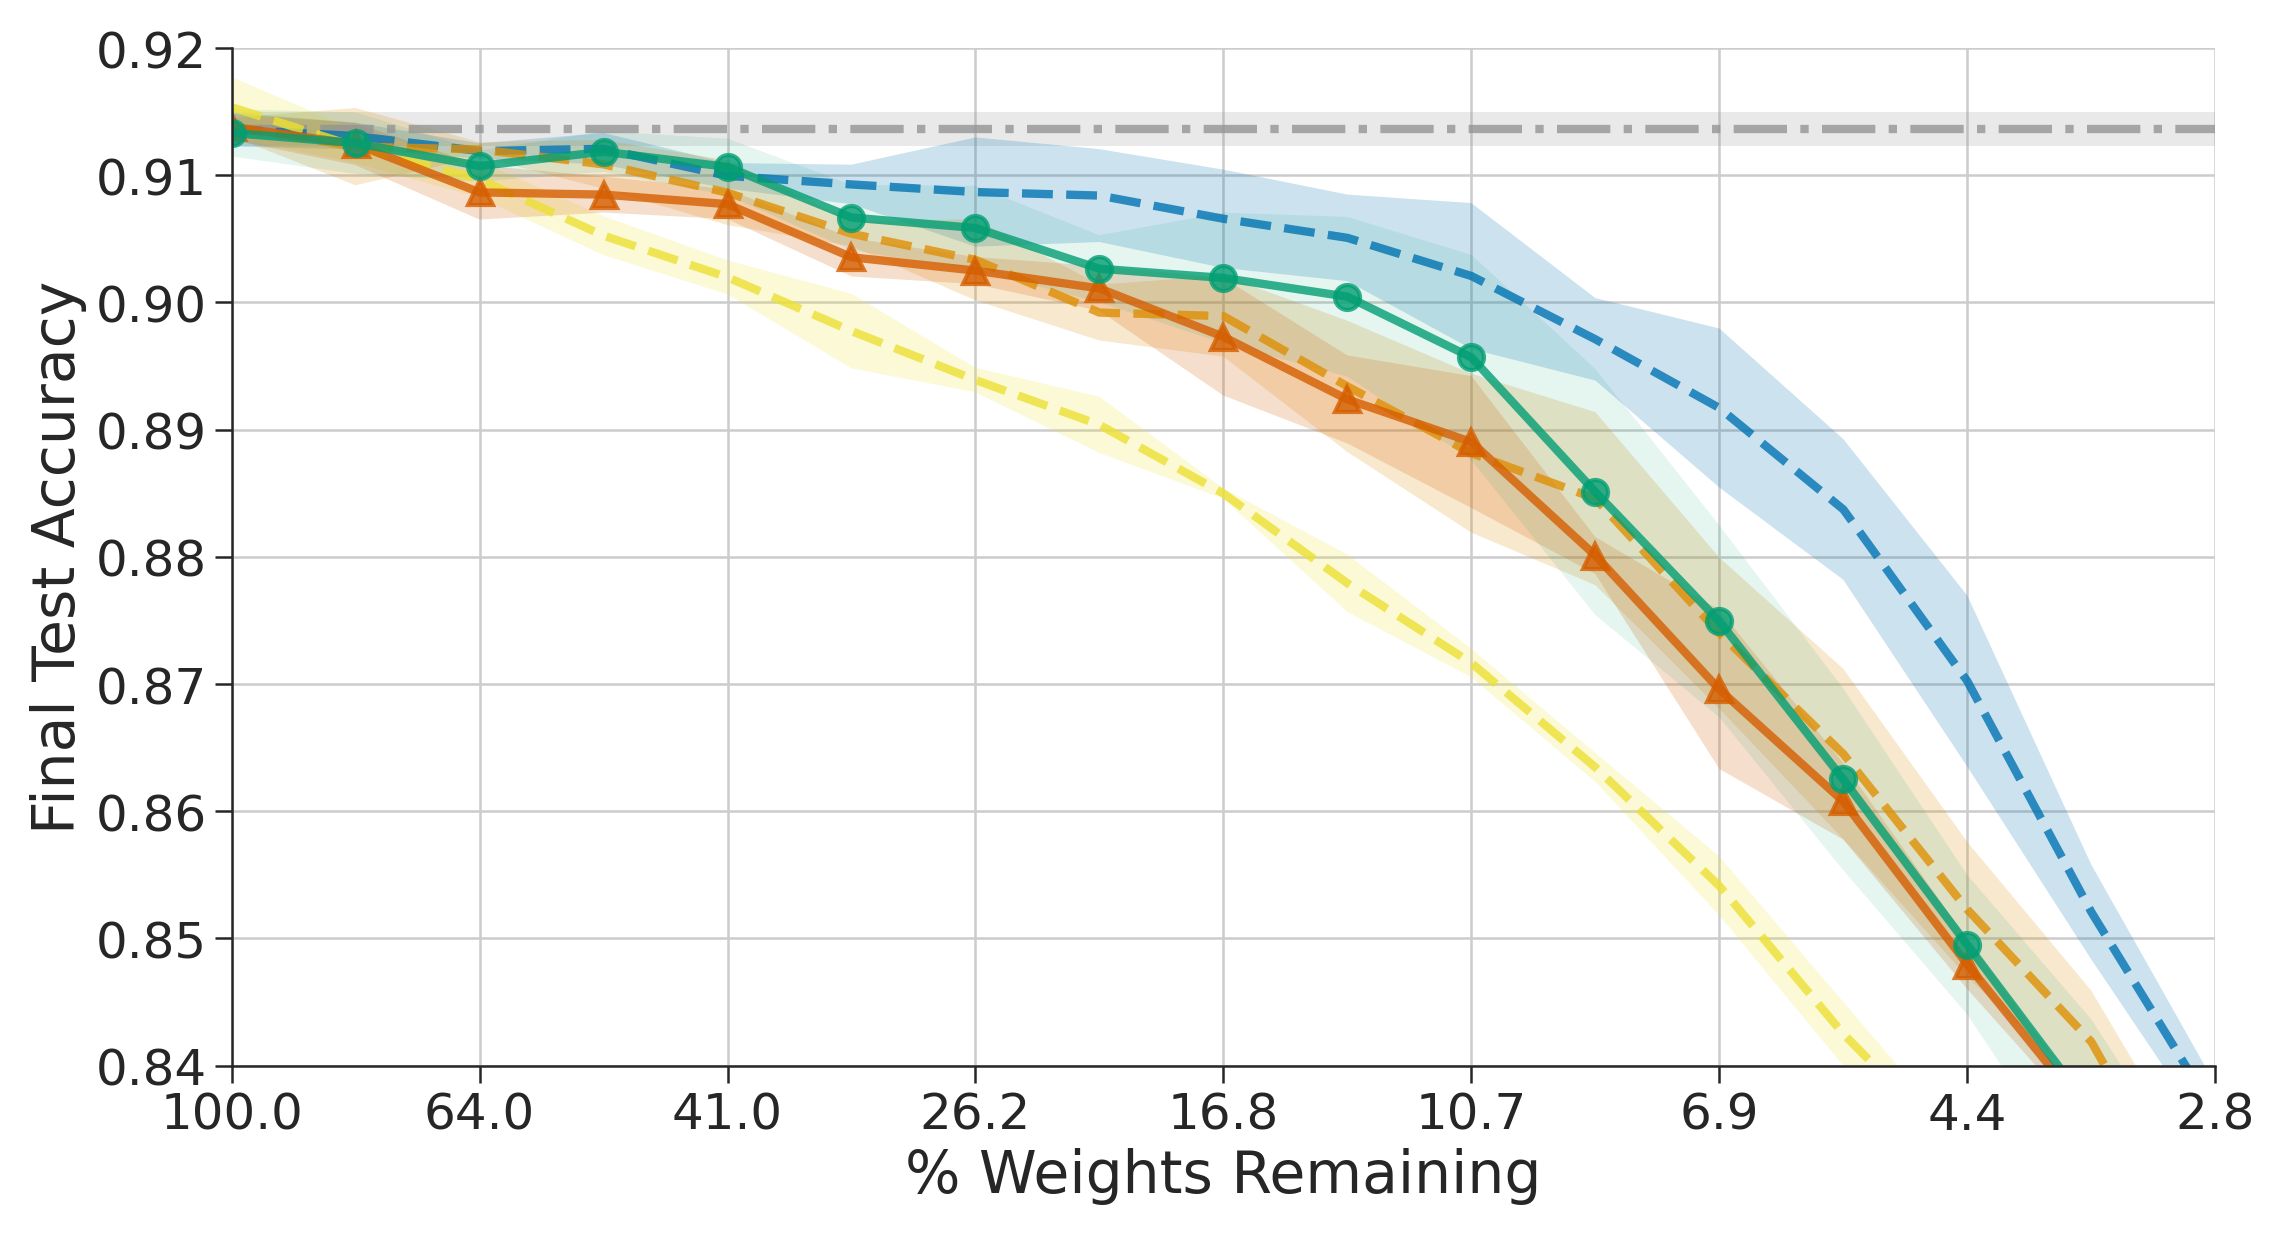

0.9136


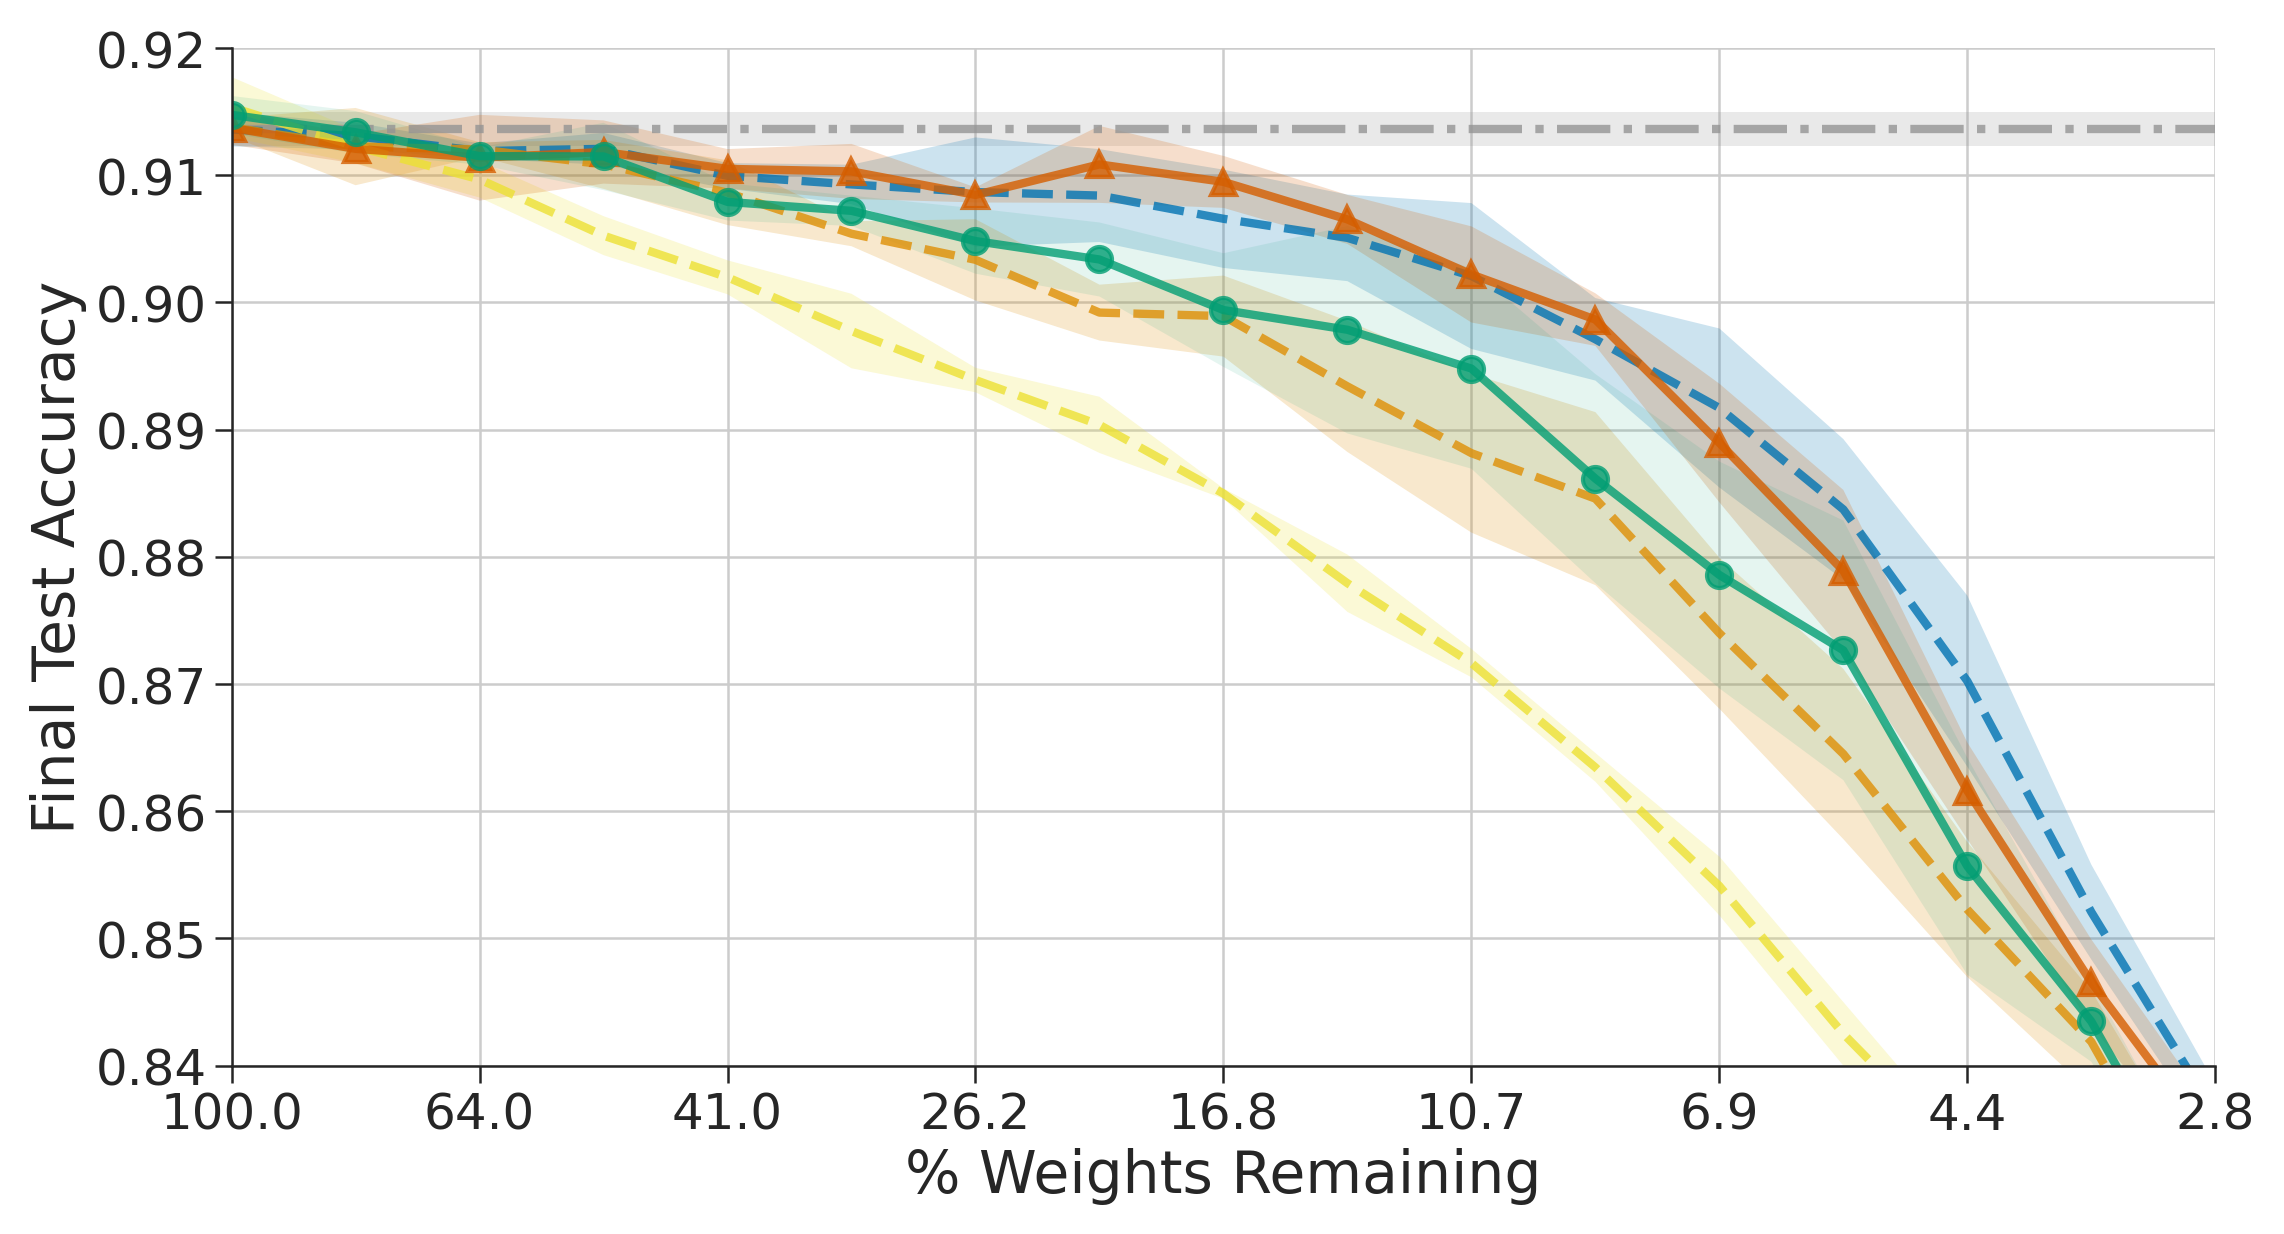

0.9136


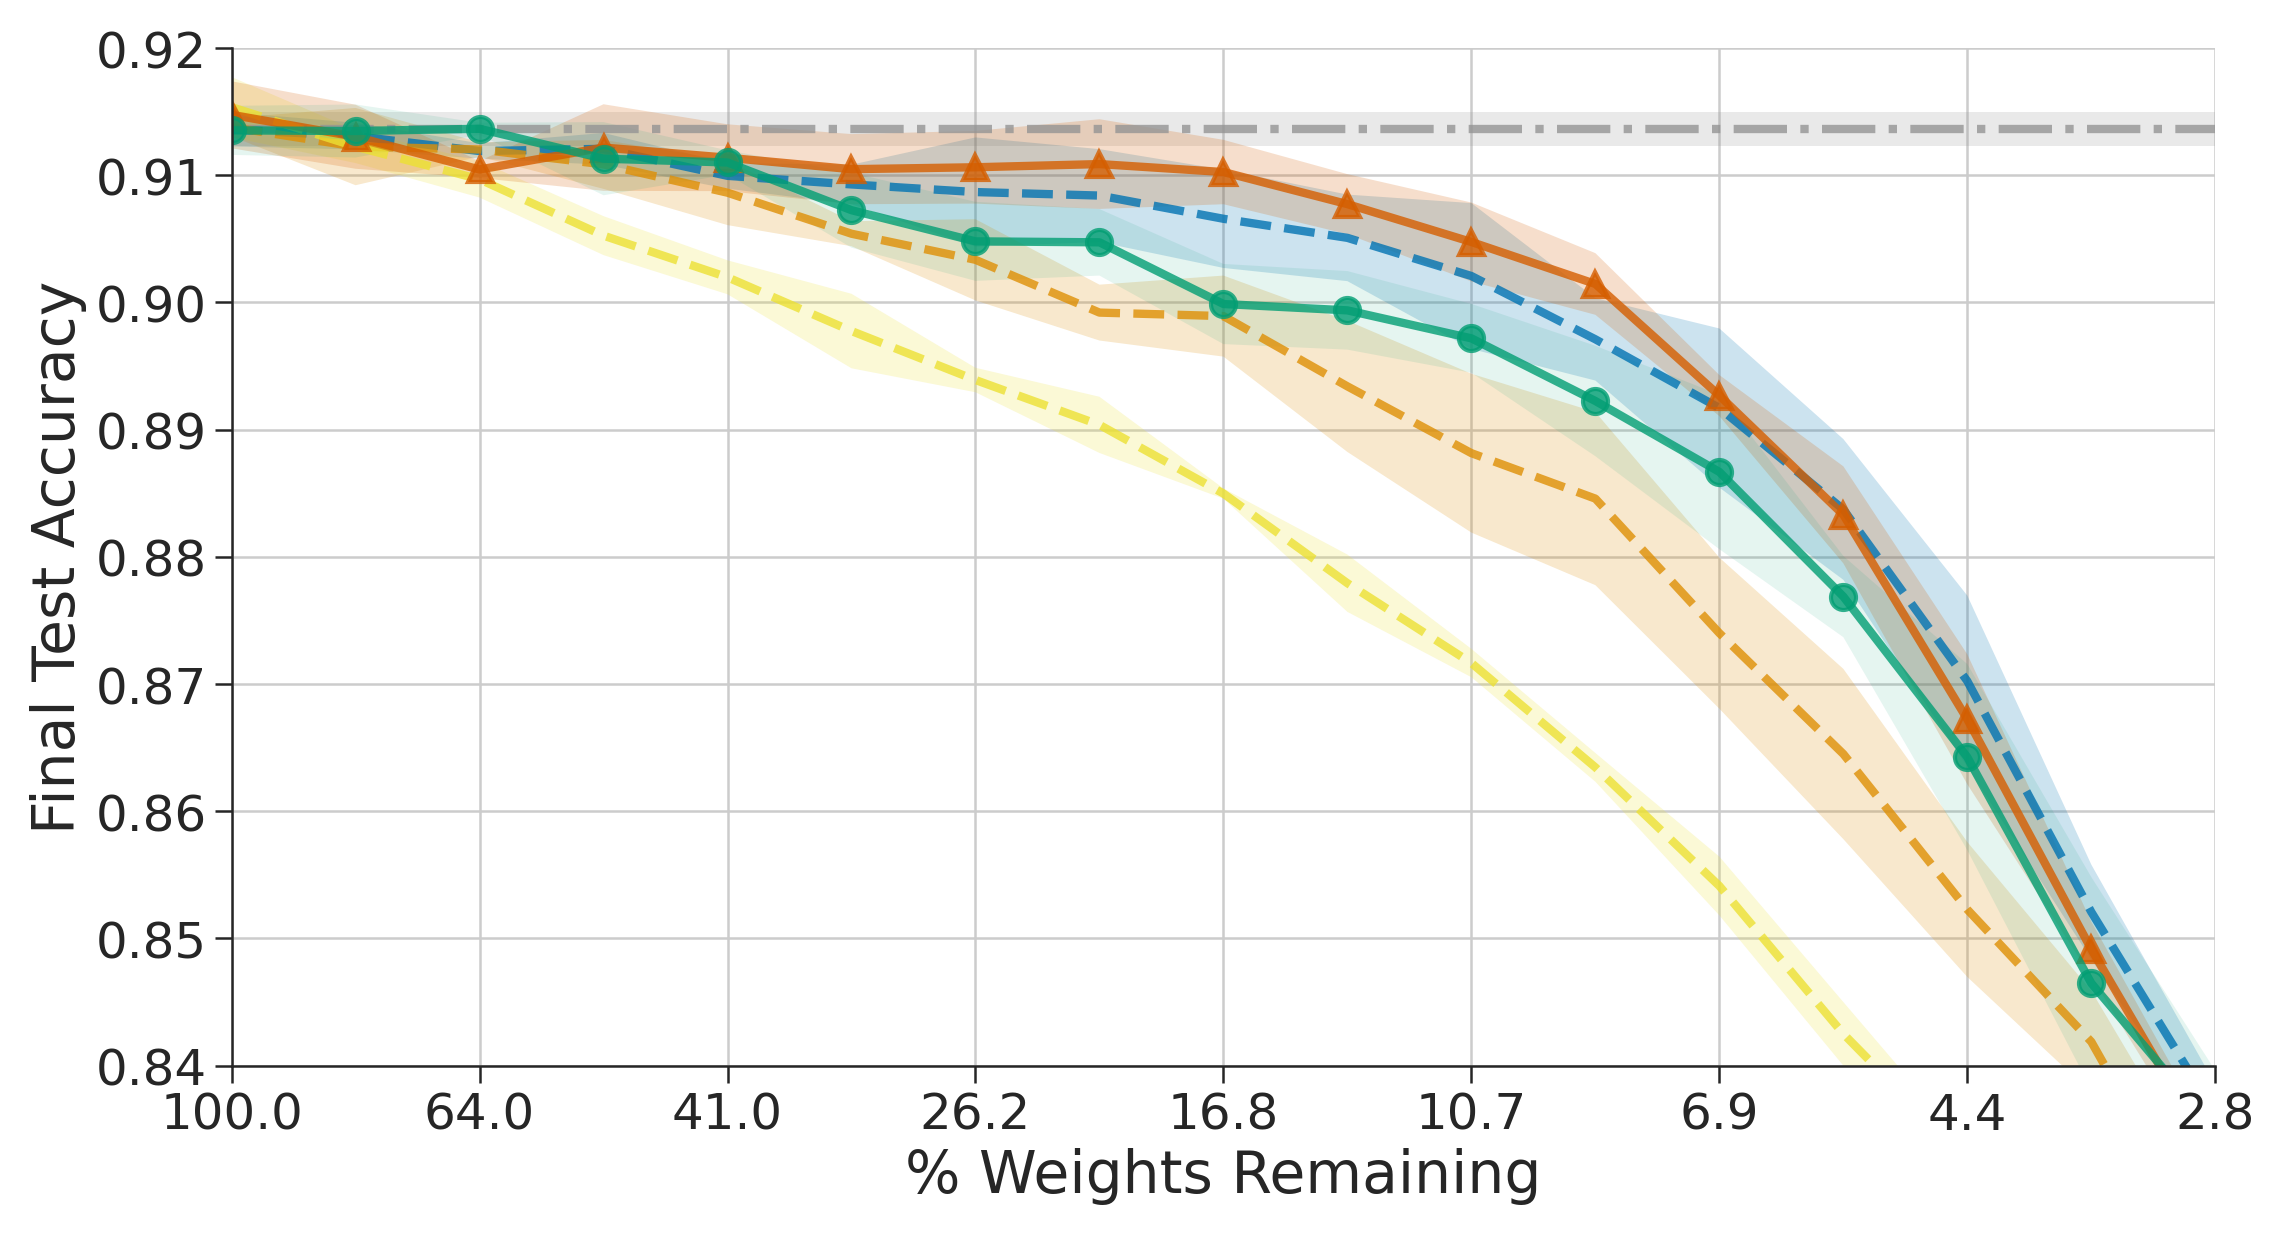

0.9136


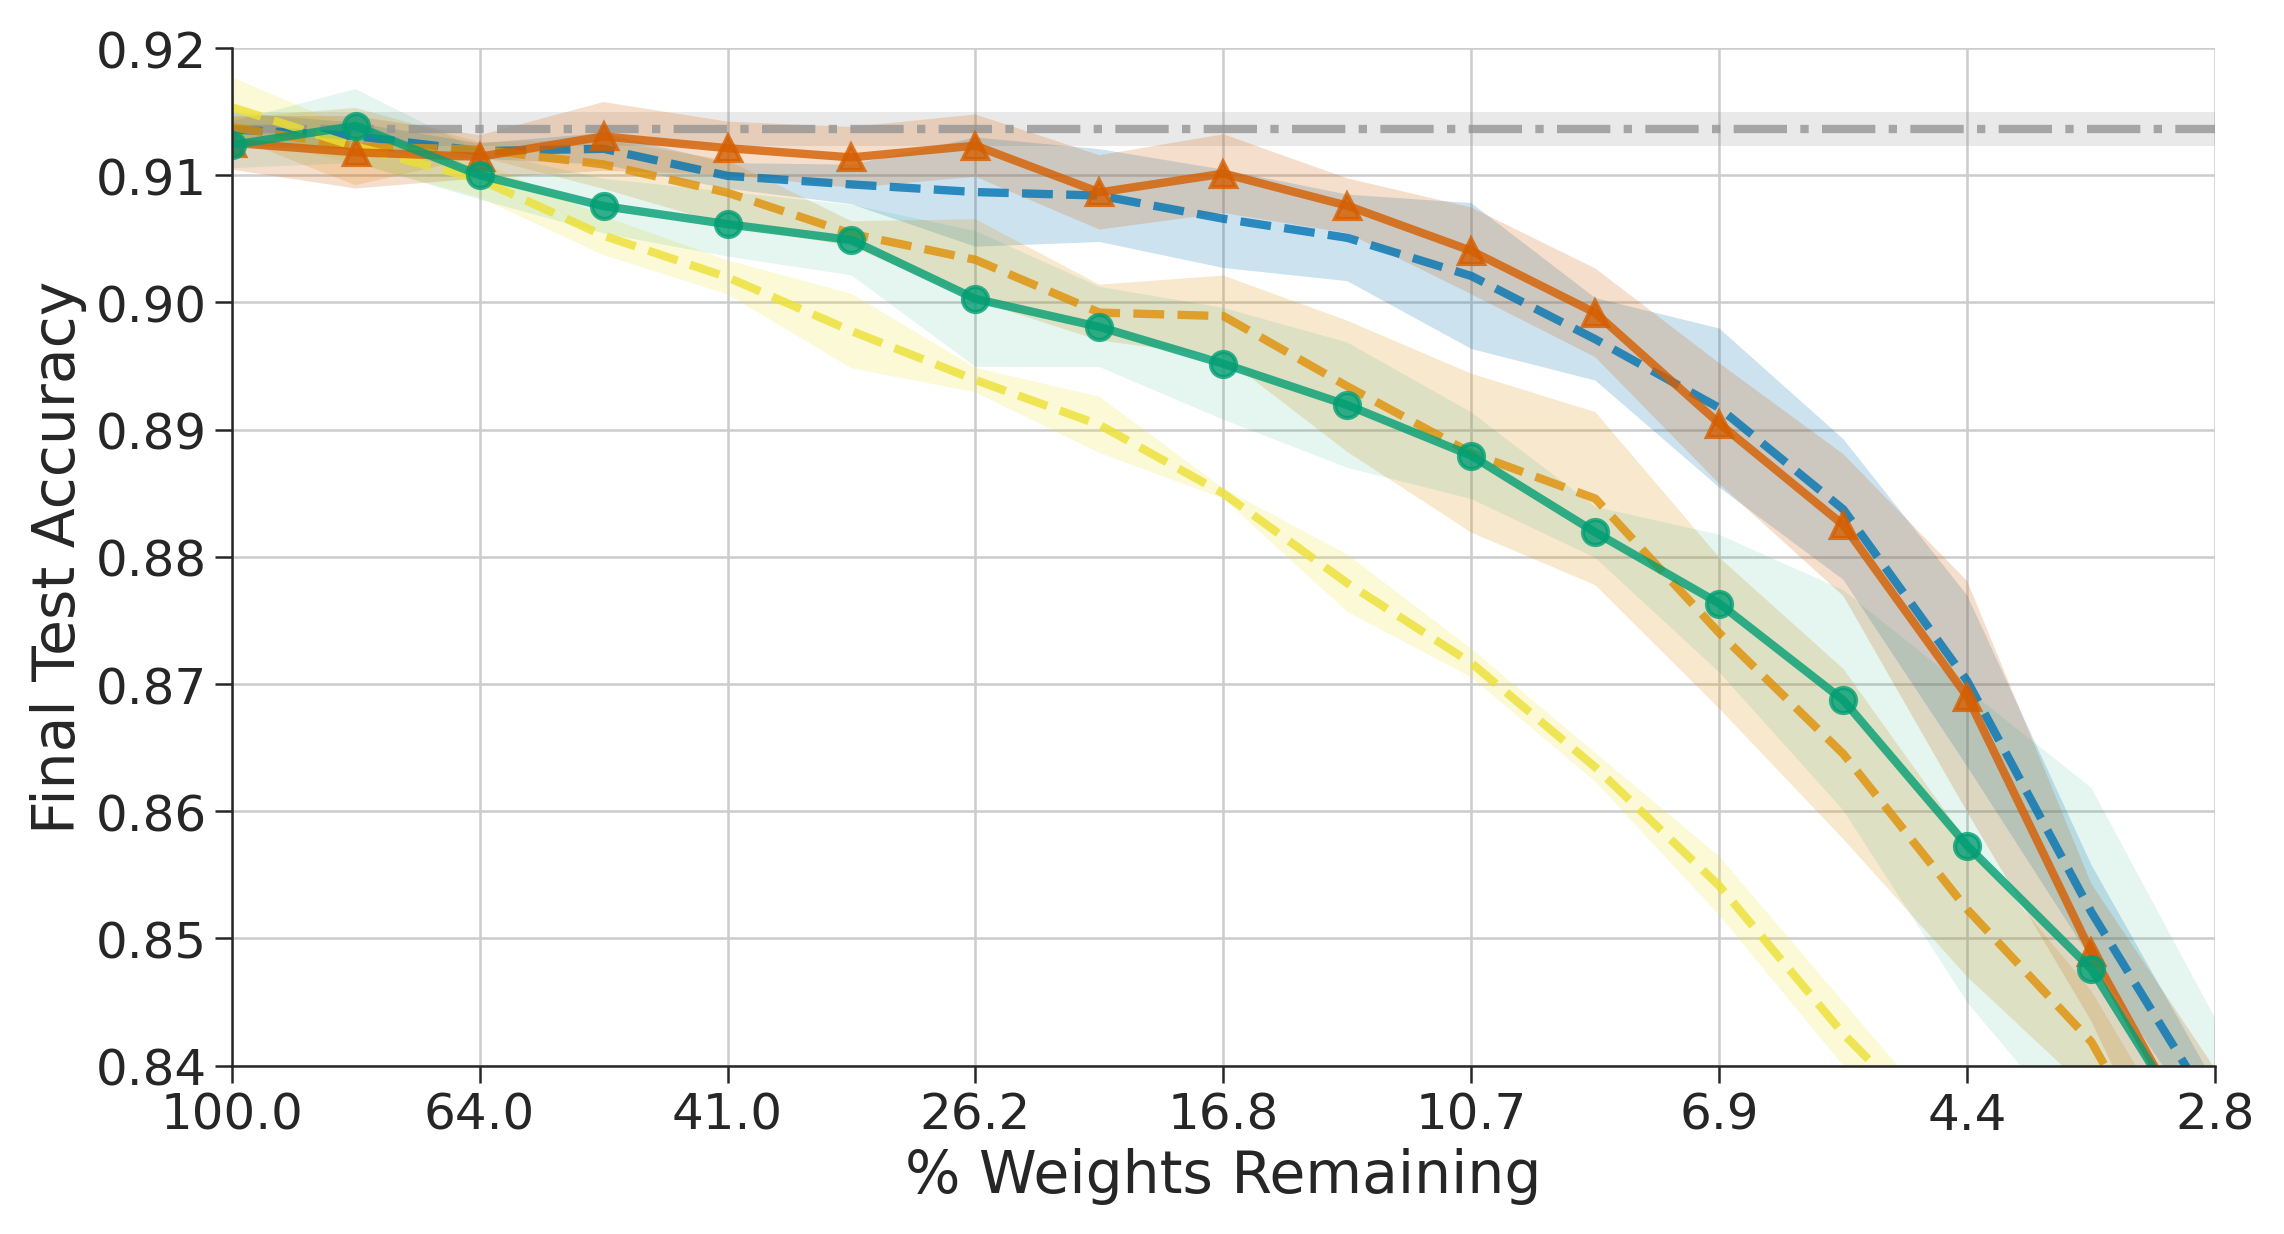

In [8]:

for i in range(len(subset_sizes)):
    plt.figure(figsize=(7.5, 4))
    ls = []

    # Plot accuracy at level 0
    x = [0, 20]
    ys = accs_all[2, :, 0]
    y_mean, y_std = ys.mean(-1), ys.std(-1)
    print(y_mean)
    c='C7'
    l = plt.axhline(y_mean, c=c, ls='-.', alpha=0.8, linewidth=2)
    plt.fill_between(x, [y_mean + y_std]*2, [y_mean - y_std]*2, color=c, alpha=0.2)
    # ls.append(l)

    # Baseline 400
    x = np.arange(21)
    ys = accs_all[2, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C0'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Baseline 200
    x = np.arange(21)
    ys = accs_all[1, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C1'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Baseline 0
    x = np.arange(21)
    ys = accs_all[0, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C8'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Easy data
    x = np.arange(21)
    ys = accs_easy[i, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C3'
    l = plt.plot(x, y_mean, c=c, marker='^', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Random data
    x = np.arange(21)
    ys = accs_rand[i, :, :]
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C2'
    l = plt.plot(x, y_mean, c=c, marker='o', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.1)

    # # Hard data
    # x = np.arange(21)
    # ys = accs_hard[i, :, :]
    # y_mean, y_std = ys.mean(0), ys.std(0)
    # c = f'C4'
    # l = plt.plot(x, y_mean, c=c, alpha=0.8, linewidth=2, marker='X')
    # ls.append(l[0])
    # plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    plt.xlim(0, 16)
    plt.ylim(0.84, 0.92)
    plt.xticks(np.arange(0, 17, 2), [f'{f*100:.1f}' for f in 0.8**np.arange(0, 17, 2)])
    plt.xlabel('% Weights Remaining')
    plt.ylabel('Final Test Accuracy')
    # plt.title('CIFAR100 ResNet32')
    sns.despine()
  
    plt.savefig(f'/home/brettlarsen/lth_diet/ipynbs/figs/cifar10_rand10_size_{subset_sizes[i]}.svg', bbox_inches='tight')
    plt.show()

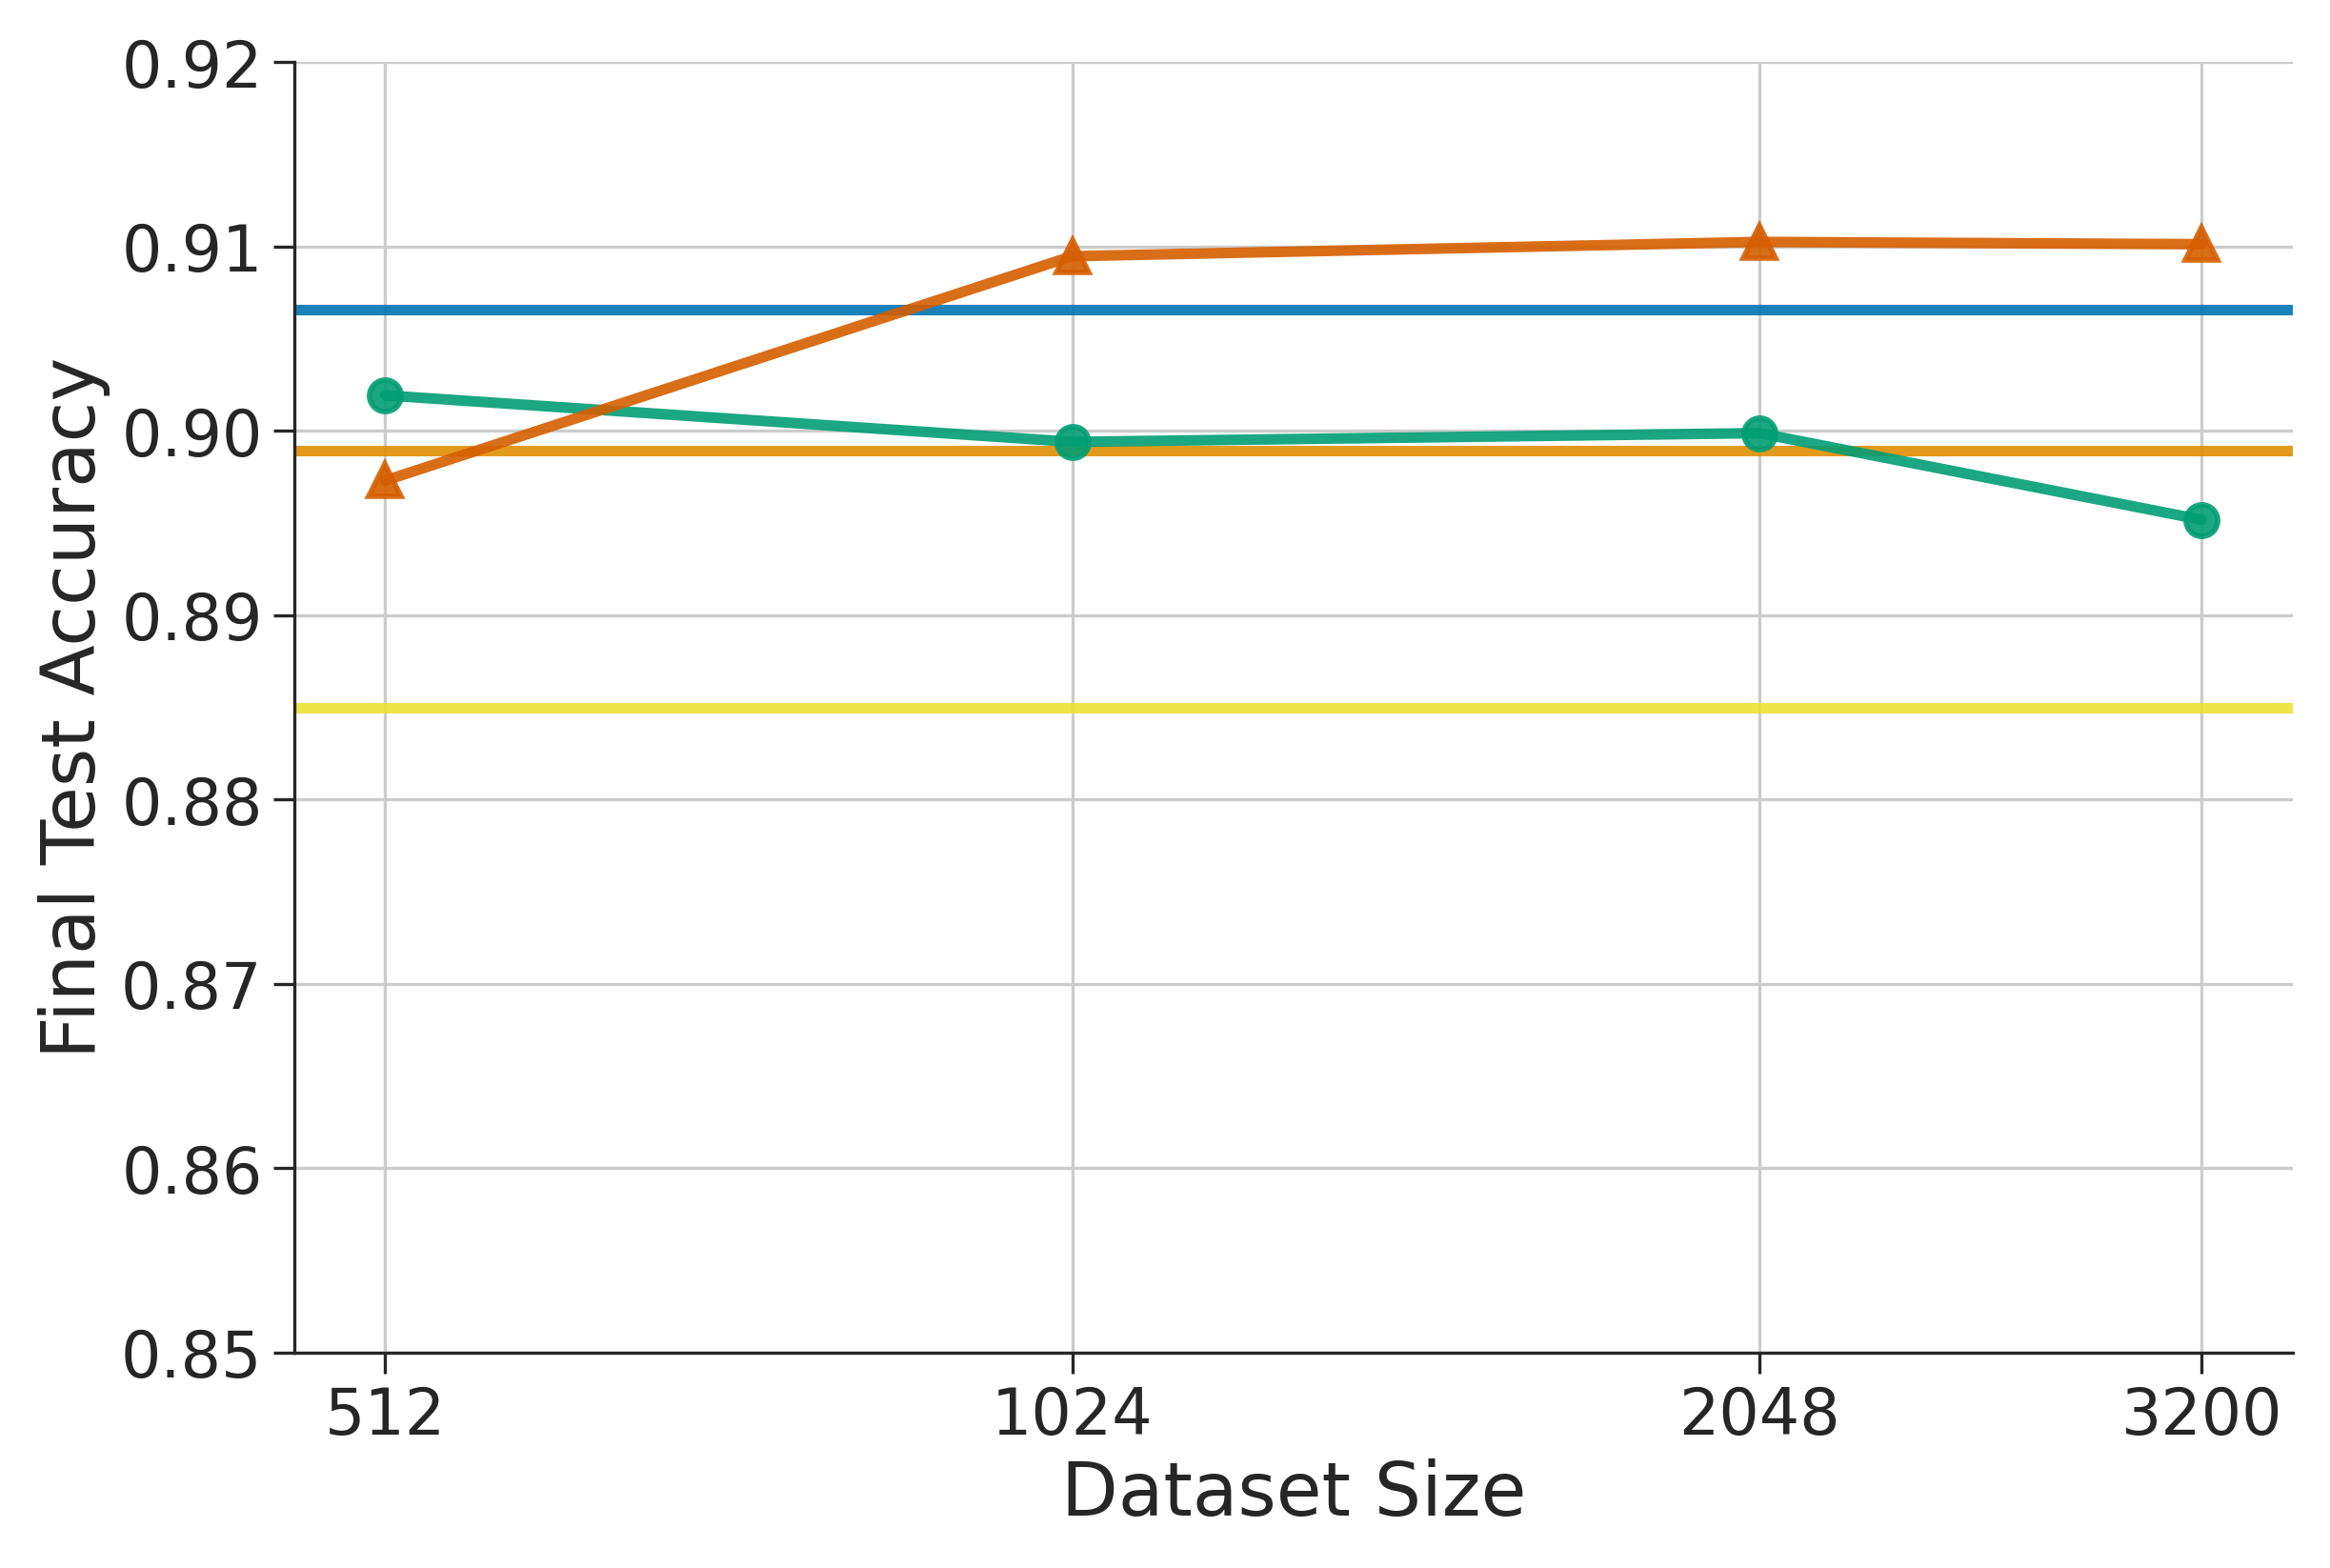

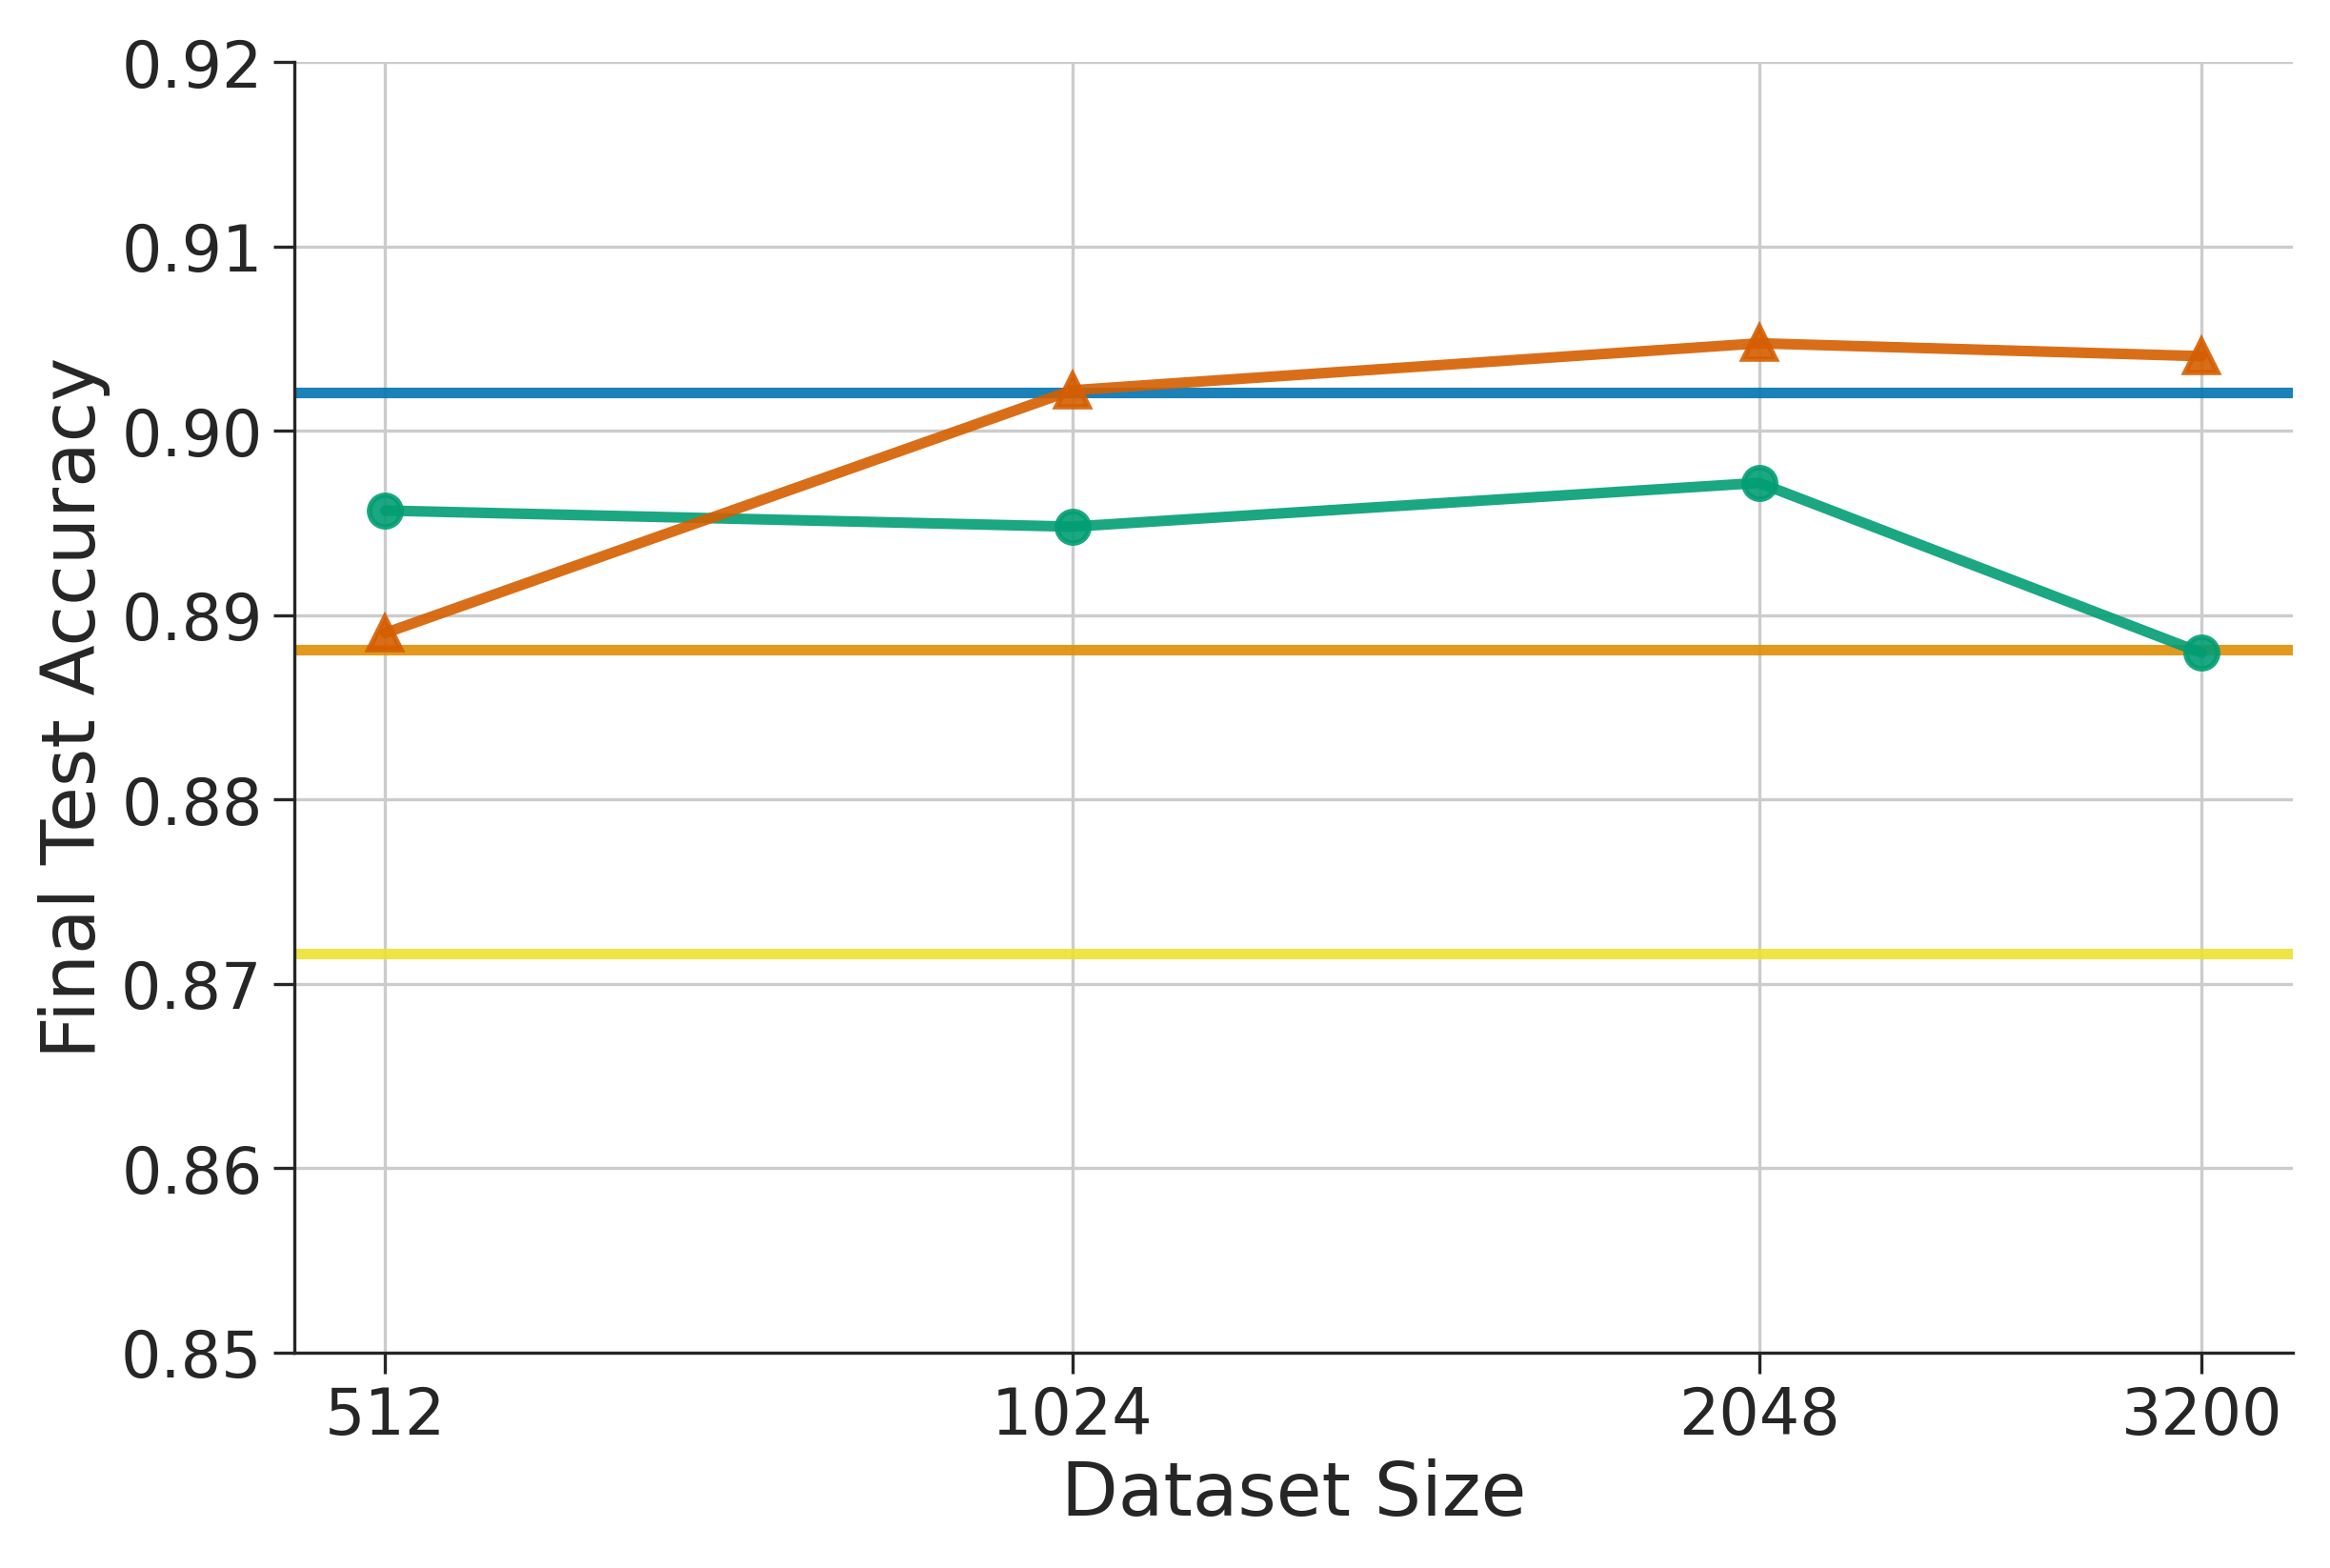

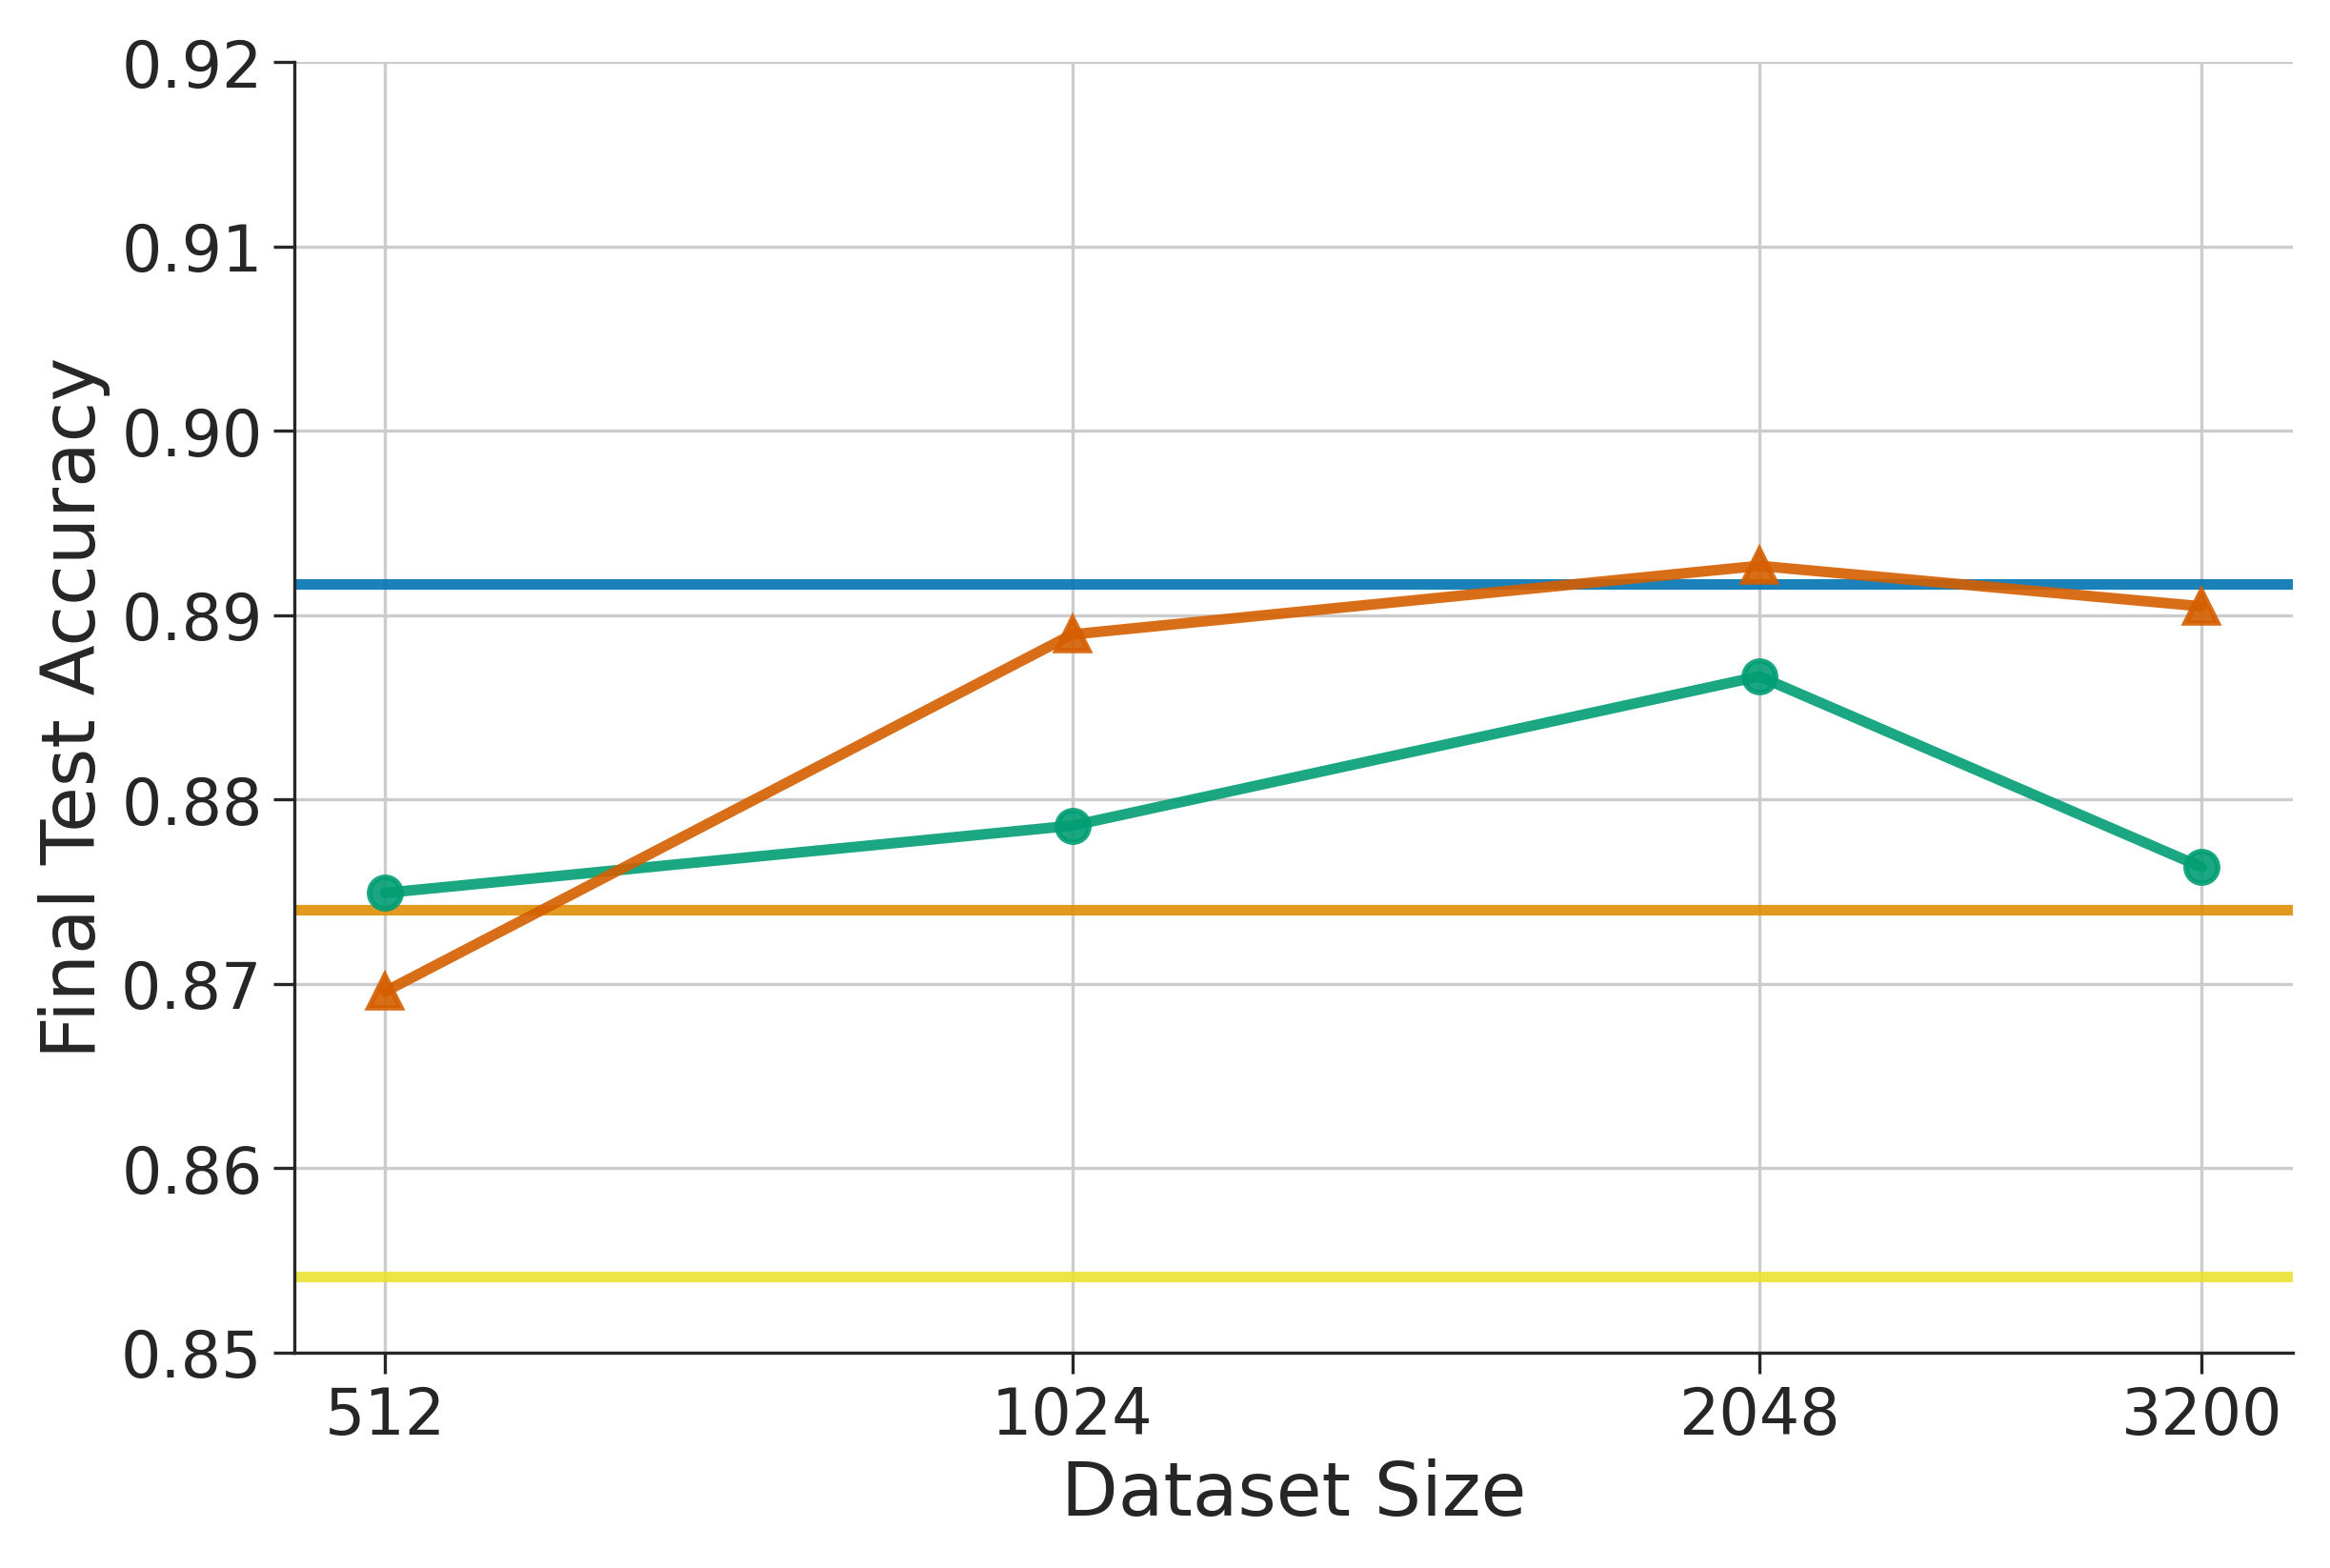

In [11]:
for end in [8, 10, 12]: 
    plt.figure(figsize=(6, 4), dpi=200)
    x = [512, 1024, 2048, 3200]
    #y_hard = [accs_hard[x_, :, end].mean() for x_ in range(len(x))]
    y_rand = [accs_rand[x_, :, end].mean() for x_ in range(len(x))]
    y_easy = [accs_easy[x_, :, end].mean() for x_ in range(len(x))]
    plt.axhline(accs_all[2, :, end].mean(), c='C0', linewidth=2, alpha=0.9)
    plt.axhline(accs_all[1, :, end].mean(), c='C1', linewidth=2, alpha=0.9)
    plt.axhline(accs_all[0, :, end].mean(), c='C8', linewidth=2, alpha=0.9)
    #plt.plot(np.log2(x), y_hard, marker='X', c='C4', linewidth=2, alpha=0.9)
    plt.plot(np.log2(x), y_rand, marker='o', c='C2', linewidth=2, alpha=0.9)
    plt.plot(np.log2(x), y_easy, marker='^', c='C3', linewidth=2, alpha=0.9)
    plt.xticks(np.log2(np.array(x)), labels=x)
    plt.xlabel('Dataset Size')
    plt.ylabel('Final Test Accuracy')
    plt.ylim(0.85, 0.92)
    sns.despine()
    plt.savefig(f'/home/brettlarsen/lth_diet/ipynbs/figs/cifar10_rand10_level_{end}.svg', bbox_inches='tight')
    plt.show()